<a href="https://colab.research.google.com/github/LihiShalmon/msc_academic_projects/blob/main/PS1_Part2_Hello_NN_2024_ID_208747287.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PS1: Your first library-free neural network!  

Advanced Learning 2024


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 208747287
~~~

~~~
STUDENT GIT LINK: [GITHUB](https://github.com/LihiShalmon/BigDataFinalProject/blob/main/PS1_Part2_Hello_NN_2024_ID_208747287.ipynb)
~~~
In Addition, don't forget to add your ID to the files:    
  
`PS1_Part2_HelloNN_2024_ID_[000000000].html`   


In [86]:
import numpy as np # You are allowed to use  only numpy.
import time
import matplotlib.pyplot as plt


**Welcome**.   

In this part of the problem set you are set to build a complete and flexible neural network.  
This neural network will be library free (in the sense that we won't use PyTorch/Tensorflow/etc.).   

Let's do a quick review of the basic neural-network components:  


*   *Layer* - can be fully connected (dense/hidden), convolution, etc.
  * Forward propagation- the layer outputs the next layer's input
  * Backward propagation- the layer also outputs the gradient descent update
*   *Activation* Layer (e.g. ReLU) - there are no parameters, only gradients with respect to the input. We want to compute both the gradient w.r.t the parameters of the layer and to create the gradient with respect to the layer's inputs
   * *Forward propagation*- the layer outputs the next layer's input
   * *Backward propagation*- the layer also outputs the gradient descent update
*   *Loss Function* : how our model  quantifies the difference between the predicted outputs the actual (target) values  
*   *Network Wrapper*-  wraps our components together as a trainable model.






Useful resource:  
* Gradient descent for neural networks [cheat sheet](https://moodle4.cs.huji.ac.il/hu23/mod/resource/view.php?id=402297).
* Neural network architecture [cheat sheet](https://moodle4.cs.huji.ac.il/hu23/mod/url/view.php?id=402298).

In [87]:
!pip install keras
!pip install numpy

### 0. Loading data

You are going to test and evaluate your home-made network on the `mnist` dataset.   
The MNIST dataset is a large dataset of handwritten digits that is commonly used for training various image and vision models.

In [88]:
from keras.datasets import mnist
from keras.utils import to_categorical
# load MNIST from server
# Using a standard library (keras.datasets) to load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#### Data transformations





In [89]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# One-hot encoding of the output.
# Currently a number in range [0,9]; Change into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

### 1. Network's Components

Please fill-in the missing code in the code boxes below (only where  `#### SOLUTION REQUIRED ####` is specified).   

In [90]:

# This class is a general layer primitive, defining that each instance must
# have an (input,output) parameters, and 2 functions: forward+backward propogation
class Layer_Primitive:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

#### Fully Connected Layer

A fully-connected layer (a.k.a. affine, dense,linear layer) connects every input neuron to every output neuron.   
It has 2 parameters: (input, output).   
You need to define (code) the following:
* its initialization weights with random weights.
* the forward propogation calculation (as shown in class).
* the backward propogation gradients calculation (given output, as shown in class).

Parameters must be intitialized with some values. There are many ways to initialize the weights, and you are encouraged to do a quick research about the common methods. Any commonly used method will be accepted.  

1.1 (20 pts)

In [91]:
#### SOLUTION REQUIRED ####


# inherit from base class Layer
class Affine_Layer(Layer_Primitive):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01  # Random initialization (small values)
        # Randomly initialize the bias of the layer
        self.bias = np.zeros((1, output_size))  # Biases initialized to zeros

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output



    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_grad, learning_rate):
        input_error = np.dot(output_grad, self.weights.T)  # dE/dX = dE/dY . W^T
        weights_error = np.dot(self.input.T, output_grad)  # dE/dW = X^T . dE/dY
        bias_error = np.sum(output_grad, axis=0, keepdims=True)  # dE/dB = sum(dE/dY)

        # Update weights and biases using gradient descent
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * bias_error

        return input_error

#### Activation layers

Activation functions are often a non-linear functions that aid in how well the network model adapts to and learns  the training dataset. The choice of activation function in the output layer will define the type of predictions the model can make.  



In [92]:
# inherit from base class Layer
class ActivationLayer(Layer_Primitive):
    def __init__(self, activation, activation_grad):
        self.activation = activation
        self.activation_grad = activation_grad

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_grad=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_grad, learning_rate):
        return self.activation_grad(self.input) * output_grad



You need to define (code) the following via different functions:
* the forward propogation calculation (as shown in class).
* the backward propogation gradients calculation (given output, as shown in class).

1.2 (20 pts)

In [93]:
import numpy as np

# Activation functions and their derivatives:
def tanh(x):
    pos_exp = np.exp(x)
    neg_exp = np.exp(-x)
    return (pos_exp - neg_exp) / (pos_exp + neg_exp)

def tanh_grad(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    x = np.clip(x, -500, 500)  # Stabilize
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    s = sigmoid(x)
    return s * (1 - s)

# Additional functions (not required to implement them)
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def softmax_grad(softmax_output):
    s = softmax_output.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


#### Loss function

1.3 (10 pts)

In [94]:
#### SOLUTION REQUIRED ####

# loss function and its derivative (with respect to y_pred, which we want to optimize)

def mse(y_true, y_pred):

    return np.mean((y_pred - y_true )**2)

def mse_grad(y_true, y_pred):
    #               scalar @ 2@ error
    return (1/y_true.shape[0])*2*(y_pred- y_true)



#### Putting everything together

1.4 (10 pts)

In [95]:
#### SOLUTION REQUIRED (in `predict`) ####

class MyNetwork:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_grad = None
        self.loss_history = []

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use_loss(self, loss, loss_grad):
        self.loss = loss
        self.loss_grad = loss_grad


    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                grad = self.loss_grad(y_train[j], output)
                for layer in reversed(self.layers):
                    grad = layer.backward_propagation(grad, learning_rate)

            # calculate average error on all samples
            err /= samples
            self.loss_history.append(err)  # Store loss
            print('Training epoch %d/%d   error=%f' % (i+1, epochs, err))


    # predict output for given input
    def predict(self, x_test,y_test=np.array([])):
        if y_test.size:
           assert len(x_test)==len(y_test) # if Y is given
        # sample dimension first
        samples = len(x_test)
        result = []
        loss = 0
        correct = 0
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = x_test[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
            # ONLY IF LABELS ARE GIVEN (Y):
            if y_test.size:
                # Evaluate the output against Y,
                # calculate loss against Y, add to `loss`:
                loss += mse(y_test, result)# FILL IN THE MISSING CODE
                target = y_test[i]
                # Evaluate the label of the output against real, and if identical (for categorical)
                if np.argmax(output) == np.argmax(target):
                   correct += 1
        if y_test.size:
            mean_loss = loss/samples

            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
                  format(mean_loss, correct, samples,100. * correct / samples))

        return result


## 2. Testing Your Neural Network

### Defining our main neural network architecture

Define your network's architecture:  
(Please rationalize your choice of activation funciton.)
* first affine layer that takes your input and outputs 128 nodes
* `tanh/relu/sigmoid` activation layer following the first affine layer
* second affine layer that takes the first layer's input and outputs 64 nodes
* `tanh/relu/sigmoid` activation layer following the second affine layer
* third affine layer that takes your second layer's input and outputs nodes in the size of the Y labels.
* `tanh/relu/sigmoid` activation layer following the last affine layer


2.1 (5 pts)

In [96]:
#### SOLUTION REQUIRED (in `predict`) ####

# Network Architecture
net = MyNetwork()
#  maps 784 (the dimensions of 28x28 image) to 128
net.add(Affine_Layer(input_size=784, output_size=128)) # First affine layer: 784 → 128
net.add(ActivationLayer(activation=relu, activation_grad=relu_grad))

#  maps 128 to 64
net.add(Affine_Layer(input_size=128, output_size=64))
net.add(ActivationLayer(activation=relu, activation_grad=relu_grad))

# maps the previous input to the labels class . we have 10 different classes since mnist classifys each image to the numbers 1-10.
net.add(Affine_Layer(input_size=64, output_size=10))
net.add(ActivationLayer(activation=sigmoid, activation_grad=sigmoid_grad))



### Training!

In [97]:

# While developing, it is recommended to train your model on a subset of the data... / or low epochs.
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use_loss(mse, mse_grad)
epoch_num = 20
lr = 0.01
t1 = time.time()
net.fit(x_train, y_train, epochs=epoch_num, learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")


Training epoch 1/20   error=0.097914
Training epoch 2/20   error=0.089171
Training epoch 3/20   error=0.069539
Training epoch 4/20   error=0.038365
Training epoch 5/20   error=0.021967
Training epoch 6/20   error=0.016952
Training epoch 7/20   error=0.014473
Training epoch 8/20   error=0.012663
Training epoch 9/20   error=0.011238
Training epoch 10/20   error=0.010083
Training epoch 11/20   error=0.009125
Training epoch 12/20   error=0.008327
Training epoch 13/20   error=0.007648
Training epoch 14/20   error=0.007066
Training epoch 15/20   error=0.006562
Training epoch 16/20   error=0.006126
Training epoch 17/20   error=0.005740
Training epoch 18/20   error=0.005401
Training epoch 19/20   error=0.005096
Training epoch 20/20   error=0.004826
Total process time: 1096.663


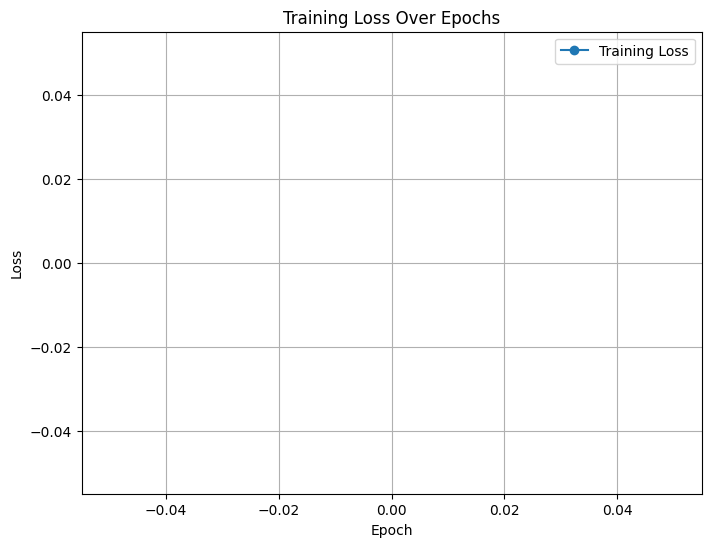

In [98]:
# Plotting the loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(net.loss_history) + 1), net.loss_history, marker='o', label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Evaluation

Exciting! Now is the time to test your model.   

    May the gradients be always in your favor.

In [99]:
output = net.predict(x_test[:4000,] ,y_test[:4000] )


Test set: Avg. loss: 0.1700, Accuracy: 3816/4000 (95%)







## 3. Benchmarking against PyTorch

How well your model performs against a similar-architecture PyTorch model?   
It is time to find out:

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

#### Prepare the data as tensors using PyTorch DataLoader:

In [101]:
t_train =  TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train))
t_test =  TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
train_loader = torch.utils.data.DataLoader(dataset=t_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=t_test, batch_size=64, shuffle=False)

In [102]:
# for images, labels in train_loader:
#     print(images.shape, labels.shape)  # Verify shapes


Define a `PyTorchNet` class with an identical architecture you used in your home-made network.

3.1 (10 pts)

In [103]:
class PyTorchNet(nn.Module):
    def __init__(self):
        super(PyTorchNet, self).__init__()
        input_size = 784  # 28x28 (flattened input size)
        num_classes = 10

        self.fc1 = nn.Linear(input_size, 128)
        self.activ1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.activ2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)
        self.activ3 = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activ1(self.fc1(x))
        x = self.activ2(self.fc2(x))
        x = self.fc3(x)
        return x


In [104]:

# Train the model
num_epochs = 20
pt_learning_rate = 0.01
pt_network = PyTorchNet()
optimizer = torch.optim.Adam(pt_network.parameters(), lr=pt_learning_rate)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = pt_network(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # A handy printout:
        if (i + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/20], Step [500/938], Loss: 0.0082
Epoch [2/20], Step [500/938], Loss: 0.0102
Epoch [3/20], Step [500/938], Loss: 0.0121
Epoch [4/20], Step [500/938], Loss: 0.0106
Epoch [5/20], Step [500/938], Loss: 0.0060
Epoch [6/20], Step [500/938], Loss: 0.0077
Epoch [7/20], Step [500/938], Loss: 0.0048
Epoch [8/20], Step [500/938], Loss: 0.0056
Epoch [9/20], Step [500/938], Loss: 0.0095
Epoch [10/20], Step [500/938], Loss: 0.0036
Epoch [11/20], Step [500/938], Loss: 0.0068
Epoch [12/20], Step [500/938], Loss: 0.0072
Epoch [13/20], Step [500/938], Loss: 0.0029
Epoch [14/20], Step [500/938], Loss: 0.0050
Epoch [15/20], Step [500/938], Loss: 0.0021
Epoch [16/20], Step [500/938], Loss: 0.0054
Epoch [17/20], Step [500/938], Loss: 0.0037
Epoch [18/20], Step [500/938], Loss: 0.0032
Epoch [19/20], Step [500/938], Loss: 0.0072
Epoch [20/20], Step [500/938], Loss: 0.0047


Evaluation:

In [105]:
pt_network.eval()
test_losses = []
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = pt_network(data)
        test_loss += criterion(output, target,)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.max(1,keepdim=True)[1]).sum()

test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.0002, Accuracy: 9466/10000 (95%)



3.2 (10 pts)

Time for some questions:
1. Which one of the models performed better? Why?
2. Which one of the models performed faster? Why?  
3. What would you change in your network's architecture?   
4. What would you change in your model's solution algorithm?

Write your solutions here:
1. To my suprise the Pytorch version reached better performence in terms of accuracy when predicting on the test set. This could probably be attributed to my regularization. The average loss of pytorch is much better.
2. Again, pytorch is better since the backend is optimized with features like:
- type checking
- parallelization, works on GPU
- optimization algorithms allow faster convergence
- uses mini batches

3. In terms or architecture -
4. Algorithmicly - I want my network to work faster.
  - I already implemented regularization of the sigmoid (clipping the function)
In the upcoming iterations I want to add:
  - Learning rate decay - gradualy reducing the learning rate along the iterations



## 4. The Network Wars!

Here is your chance to play with your model's architecture in order to break your own benchmark set eariler.  
You can add/remove layers, play with their sizes, types, etc.   
You can add a new loss if you wish, or anything else that will fairly give your model an advantage over base.  

4.1 (15 pts)

In [106]:
# Define network architecture
net_update = MyNetwork()

# Layer 1: Fully connected with ReLU
net_update.add(Affine_Layer(input_size=784, output_size=128))
net_update.add(ActivationLayer(activation=relu, activation_grad=relu_grad))

# Layer 2: Fully connected with ReLU
net_update.add(Affine_Layer(input_size=128, output_size=64))
net_update.add(ActivationLayer(activation=relu, activation_grad=relu_grad))

# Output Layer: Fully connected with Softmax
net_update.add(Affine_Layer(input_size=64, output_size=10))
net_update.add(ActivationLayer(activation=softmax, activation_grad=None))  # Final softmax


In [113]:
#### SOLUTION REQUIRED (in `predict`) ####

class MyNetwork:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_grad = None
        self.loss_history = []

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use_loss(self, loss, loss_grad):
        self.loss = loss
        self.loss_grad = loss_grad


    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)
        decay = 0.01
        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                grad = self.loss_grad(y_train[j], output)
                for layer in reversed(self.layers):
                    learning_rate = learning_rate
                    grad = layer.backward_propagation(grad, learning_rate)

            # calculate average error on all samples
            err /= samples
            self.loss_history.append(err)  # Store loss
            print('Training epoch %d/%d   error=%f' % (i+1, epochs, err))


    # predict output for given input
    def predict(self, x_test,y_test=np.array([])):
        if y_test.size:
           assert len(x_test)==len(y_test) # if Y is given
        # sample dimension first
        samples = len(x_test)
        result = []
        loss = 0
        correct = 0
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = x_test[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
            # ONLY IF LABELS ARE GIVEN (Y):
            if y_test.size:
                # Evaluate the output against Y,
                # calculate loss against Y, add to `loss`:
                loss += mse(y_test, result)# FILL IN THE MISSING CODE
                target = y_test[i]
                # Evaluate the label of the output against real, and if identical (for categorical)
                if np.argmax(output) == np.argmax(target):
                   correct += 1
        if y_test.size:
            mean_loss = loss/samples

            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
                  format(mean_loss, correct, samples,100. * correct / samples))

        return result


In [ ]:
loss_history = []
net_update.use_loss(mse, mse_grad)
epoch_num = 20
lr = 0.01
t1 = time.time()
net.fit(x_train, y_train, epochs=epoch_num, learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")


Training epoch 1/20   error=0.001889
Training epoch 2/20   error=0.001836


In [ ]:
output = net_update.predict(x_test[:4000,] ,y_test[:4000] )